In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

from catboost import CatBoostClassifier
from sklearn.tree import plot_tree
from catboost import CatBoost, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV
from myfunctions import prediction_matrices

import warnings
warnings.filterwarnings("ignore")

## Import DataFrame which is not One-Hot-Encoded

In [3]:
df_train = pd.read_pickle('./data/df_train_KNN.pkl')
df_test = pd.read_pickle('./data/df_test_KNN.pkl')

In [4]:
# Examine dtype for categorial features
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27770 entries, 3313 to 15795
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       27770 non-null  int64   
 1   gender                    27770 non-null  category
 2   region_category           27770 non-null  category
 3   membership_category       27770 non-null  object  
 4   joined_through_referral   27770 non-null  category
 5   preferred_offer_types     27770 non-null  category
 6   medium_of_operation       27770 non-null  category
 7   internet_option           27770 non-null  category
 8   days_since_last_login     27770 non-null  int64   
 9   avg_time_spent            27770 non-null  float64 
 10  avg_transaction_value     27770 non-null  float64 
 11  avg_frequency_login_days  27770 non-null  float32 
 12  points_in_wallet          27770 non-null  float64 
 13  used_special_discount     27770 non-null  catego

In [5]:
# Convert 'membership_category' into categorial dtype
df_train['membership_category'] = df_train['membership_category'].astype('category')
df_test['membership_category'] = df_test['membership_category'].astype('category')

# Assign Target and Features

In [6]:
X_train = df_train.drop("churn_risk_score", axis = 1)
y_train = df_train["churn_risk_score"]

X_test = df_test.drop("churn_risk_score", axis = 1)
y_test = df_test["churn_risk_score"]

In [7]:
#X_train_train = X_train.astype(float)
y_train = y_train.astype(int)

y_test = y_test.astype(int)

In [8]:
# create a list of categorial features (Catboost needs this)
cat_features = df_train.select_dtypes(include=['category']).columns.tolist()
# Show the list of categorial features
print(cat_features)  
# Create CatBoost classifer object
model = CatBoostClassifier()

# Train CatBoost Classifer
model.fit(X_train,y_train, cat_features=cat_features)

#Predict the response for test dataset
y_pred = model.predict(X_test)

['gender', 'region_category', 'membership_category', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'used_special_discount', 'complaint_status', 'feedback']
Learning rate set to 0.042593
0:	learn: 0.6227088	total: 74.5ms	remaining: 1m 14s
1:	learn: 0.5633240	total: 88.3ms	remaining: 44.1s
2:	learn: 0.5148198	total: 107ms	remaining: 35.4s
3:	learn: 0.4715426	total: 120ms	remaining: 29.8s
4:	learn: 0.4414302	total: 135ms	remaining: 26.8s
5:	learn: 0.4138425	total: 150ms	remaining: 24.8s
6:	learn: 0.3787006	total: 169ms	remaining: 24s
7:	learn: 0.3494125	total: 184ms	remaining: 22.8s
8:	learn: 0.3271590	total: 201ms	remaining: 22.1s
9:	learn: 0.3127644	total: 213ms	remaining: 21.1s
10:	learn: 0.3014808	total: 231ms	remaining: 20.8s
11:	learn: 0.2841211	total: 246ms	remaining: 20.3s
12:	learn: 0.2681325	total: 257ms	remaining: 19.5s
13:	learn: 0.2539250	total: 272ms	remaining: 19.1s
14:	learn: 0.2473006	total: 286ms	remaining: 18.8s
15:	learn:

## Prediction scores and matrices

Report on train set : 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     12798
           1       0.96      0.98      0.97     14972

    accuracy                           0.96     27770
   macro avg       0.96      0.96      0.96     27770
weighted avg       0.96      0.96      0.96     27770

--------------------------------------------------------------------------------
Accuracy on test set: 0.94
ROC on test set: 0.98
Report on test set : 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      3167
           1       0.93      0.95      0.94      3779

    accuracy                           0.94      6946
   macro avg       0.94      0.93      0.94      6946
weighted avg       0.94      0.94      0.94      6946



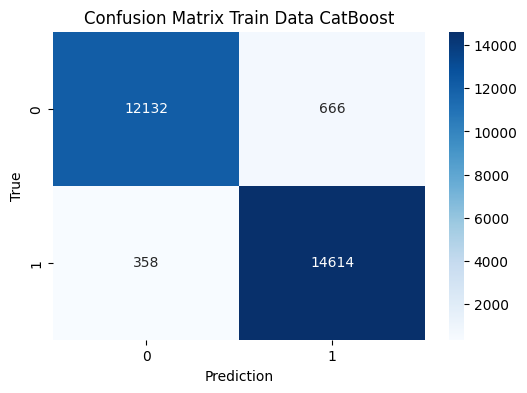

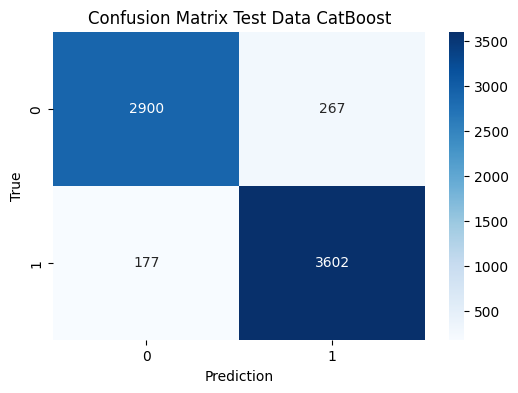

In [9]:
#plot prediction matrices
prediction_matrices(model = model, X_train= X_train, X_test= X_test, y_train=y_train, y_test= y_test, model_name= "CatBoost")

The comparison of the predictions based on train and test data suggest an overfitting that is typical for decison trees (when not pruned). The prediction on train data results in perfect scores, while the prediction on test data scored around 91%.

In [10]:
# Scores
print("Scores for decision tree")
print("________________________________")
print('F1-Score=%.3f' % (f1_score(y_test, y_pred)))
print('Precision=%.3f, Recall=%.3f, Accuracy = %.3f' % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy_score(y_test, y_pred)))

Scores for decision tree
________________________________
F1-Score=0.942
Precision=0.931, Recall=0.953, Accuracy = 0.936


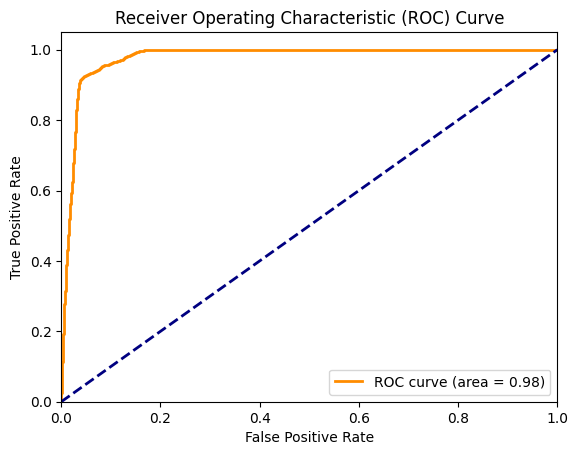

In [11]:
# ROC Curve
y_pred_roc = model.predict_proba(X_test)[:, 1] # Probability of positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_roc)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Visualize the catBoost tree

In [17]:
#Show the total number of trees in the CatBoost-model
num_trees = model.tree_count_
print(num_trees)

1000


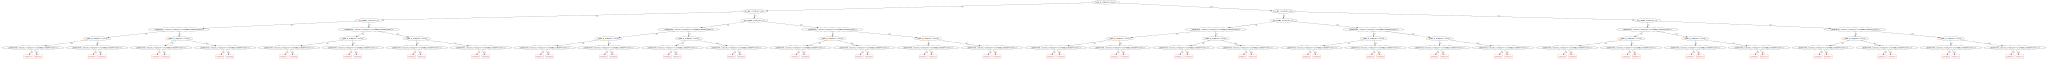

In [16]:
# Instantitate pool variable to label features in the plot
pool = Pool(X_train, y_train, cat_features=cat_features, feature_names=list(X_train.columns))
# plot an example tree (could be selected by the index)
model.plot_tree(tree_idx=1, pool=pool)

The plot shows only one tree of our CatBoost-model which contains 1000 trees. The resulting 'val'-values of all trees are combined using a sigmoid function and lead to the classification result. val= 0.000 means that this leaf of this tree has no influence on the prediction, because other trees contribute more to the prediction. 

## Feature Importance

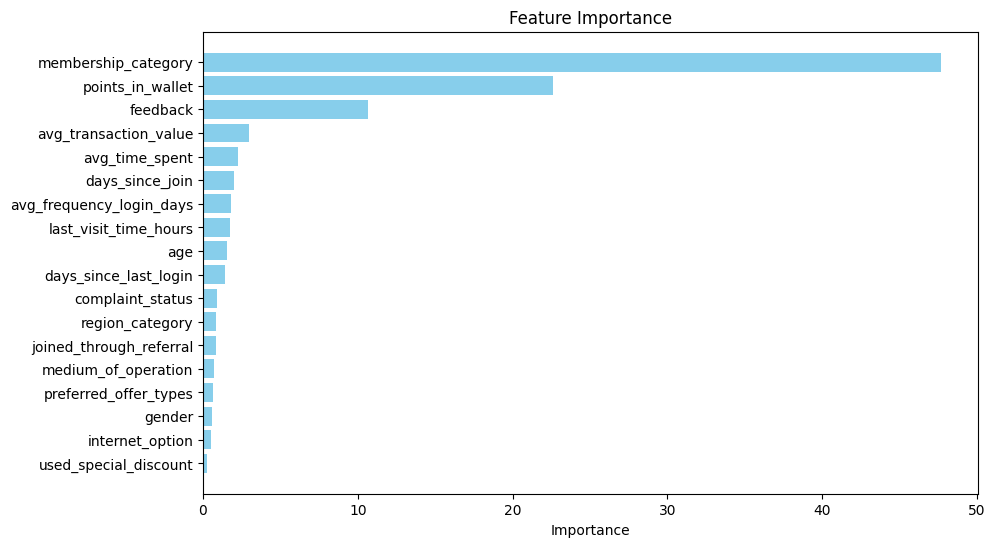

In [13]:
#feature importance
importances = model.feature_importances_
features = X_train.columns


# create data frame for handling importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# sort by importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# create Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

cleaned until here
---------------
please comment and work on from here
---------------
17.04.2024

The results are mainly based on two features: membership_category and points_in_wallet. Further features that play a medium role mainly indicate the historical and recent interaction of the customer with the platform (e.g., avg_time_spent). Interestingly, feedback does not play an important role for the prediction (contrary to our learnings from the EDA).

## Save Model

In [ ]:
# Save model
with open('./model/model_CatBoost.pkl', 'wb') as file:
    pickle.dump(model, file)

# Hyperparameter tuning inclusive cross-validation
Considering the obvious overfitting from the previous model, we use cross-validation (cv) and pruning to increase the robustness of our model and reduce overfitting.

- iterations: Dieser Parameter legt die Anzahl der Boosting-Iterationen (Bäume) fest, die während des Trainings verwendet werden sollen2.
- learning_rate: Dieser Parameter steuert die Schrittgröße bei jeder Iteration, während man sich auf ein Minimum der Verlustfunktion zubewegt12.
- depth: Bestimmt die maximale Tiefe der einzelnen Entscheidungsbäume im Ensemble2.
- l2_leaf_reg: Regularisierungsterm, der Overfitting verhindert, indem er große Parameterwerte bestraft2.
- cat_features: Ein Array von Indizes, die angeben, welche Merkmale kategorisch sind2.
- loss_function: Legt die zu optimierende Verlustfunktion während des Trainings fest2.

In [ ]:
# Defining parameter grid (as dictionary)
model_grid = CatBoostClassifier()

param_grid = {
    'max_depth': [1, 3, 6, 9, 25],
    'min_impurity_decrease': [0.001, 0.01, 0.1],
    'min_samples_leaf': [3, 5, 25, 50],
}

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(clf_grid,
                  param_grid,
                  cv=5,
                  verbose=5,
                  scoring= "f1",
                  n_jobs=-1)

# Fit gridsearch object to data
gs.fit(X_train, y_train)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 5/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.842 total time=   0.2s
[CV 3/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.848 total time=   0.2s
[CV 1/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.846 total time=   0.2s
[CV 4/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.843 total time=   0.3s
[CV 1/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=5;, score=0.846 total time=   0.3s
[CV 2/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.842 total time=   0.3s
[CV 2/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=5;, score=0.842 total time=   0.3s
[CV 3/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=5;, score=0.848 total time=   0.2s
[CV 4/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=5;, score=

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 6, 9, 25],
                         'min_impurity_decrease': [0.001, 0.01, 0.1],
                         'min_samples_leaf': [3, 5, 25, 50]},
             scoring='f1', verbose=5)

In [ ]:
# check parameters after GridSearch
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Best score: 0.932
Best parameters: {'max_depth': 6, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 3}


In [ ]:
# Get the best model from the grid search
best_model = gs.best_estimator_

#predict test
y_pred_grid = best_model.predict(X_test)

Report on train set : 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92     11105
           1       0.95      0.91      0.93     13215

    accuracy                           0.93     24320
   macro avg       0.92      0.93      0.93     24320
weighted avg       0.93      0.93      0.93     24320

--------------------------------------------------------------------------------
Accuracy on test set: 0.92
ROC on test set: 0.97
Report on test set : 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      4860
           1       0.95      0.91      0.93      5536

    accuracy                           0.92     10396
   macro avg       0.92      0.92      0.92     10396
weighted avg       0.92      0.92      0.92     10396



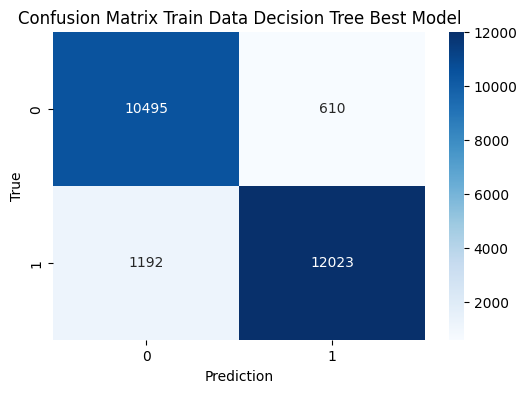

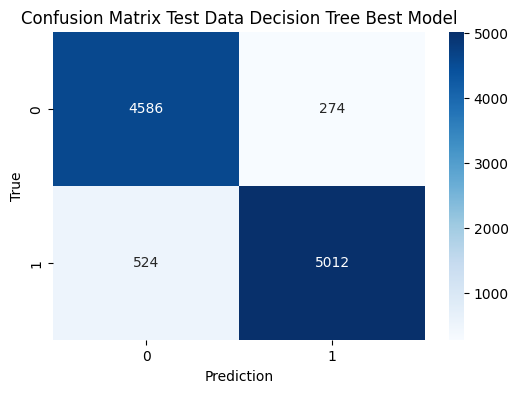

In [ ]:
# show prediction scores
prediction_matrices(model = best_model, X_train= X_train, X_test= X_test, y_train=y_train, y_test= y_test, model_name= "Decision Tree Best Model")



The pruning of the decision tree was succesfull. The results for train and test data for all relevant scores are within a similar range.

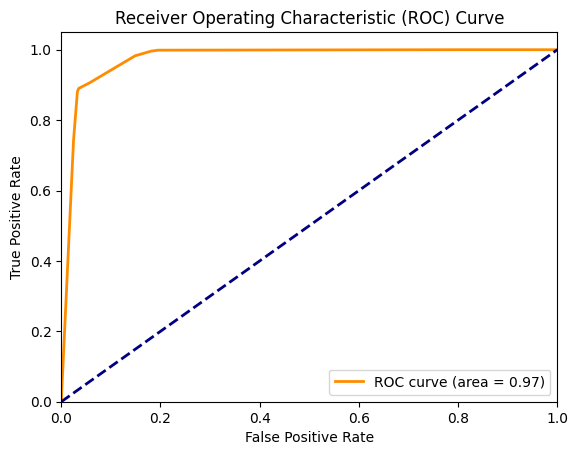

In [ ]:
# ROC Curve
y_pred_roc = best_model.predict_proba(X_test)[:, 1] # Probability of positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_roc)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Scores
print("Scores for hyperparameter tuned decision tree")
print("________________________________")
print('F1-Score=%.3f' % (f1_score(y_test, y_pred_grid)))
print('Precision=%.3f, Recall=%.3f, Accuracy = %.3f' % (precision_score(y_test, y_pred_grid), recall_score(y_test, y_pred_grid), accuracy_score(y_test, y_pred_grid)))


Scores for hyperparameter tuned decision tree
________________________________
F1-Score=0.926
Precision=0.948, Recall=0.905, Accuracy = 0.923


**Note**
For model types like logistic regression, the idea of thresholds is to convert a probability into a discrete class based on a given threshold. However, decision trees already predict discrete classes ("hard class assignment") and does not use probabilities for that. Therefore, we cannot change thresholds in order to optimize our model for a specific use case.

## Distribution of Prediction Probabilities
Nonetheless, the concept of probabilities exist for decision trees in another form.
In decision trees, samples are sorted into different leaves based on optimized splitting criteria to achieve maximum homogeneity or ‘purity’. The predicted probability for a class in a leaf node is given by the proportion of samples of that class in the node. As a result, especially in deep trees, many samples may end up in ‘pure’ leafs where all samples belong to a single class (0 or 1).
As shown in "Distribution of prediction probabilities" (below), one can see that the vast majority of samples are sorted into pure leafs (0 or 1).

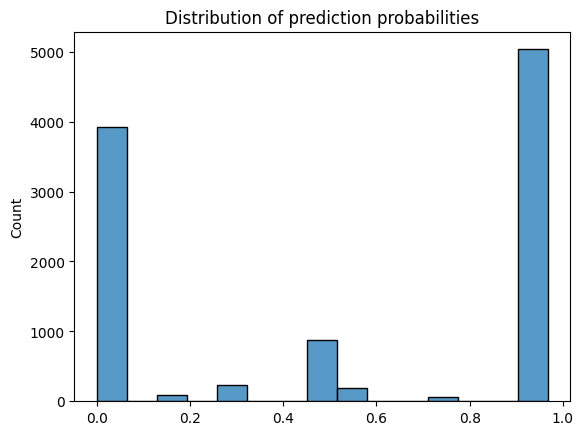

In [ ]:
# get probabilities for predictions on X_test
y_probe = best_model.predict_proba(X_test)

# plot distribution of prediction probabilities
fig = sns.histplot(y_probe[:,1]) #get probabilities for churn_risk_score = 1
plt.title("Distribution of prediction probabilities")
plt.show(fig)


## Visualize Decision Tree

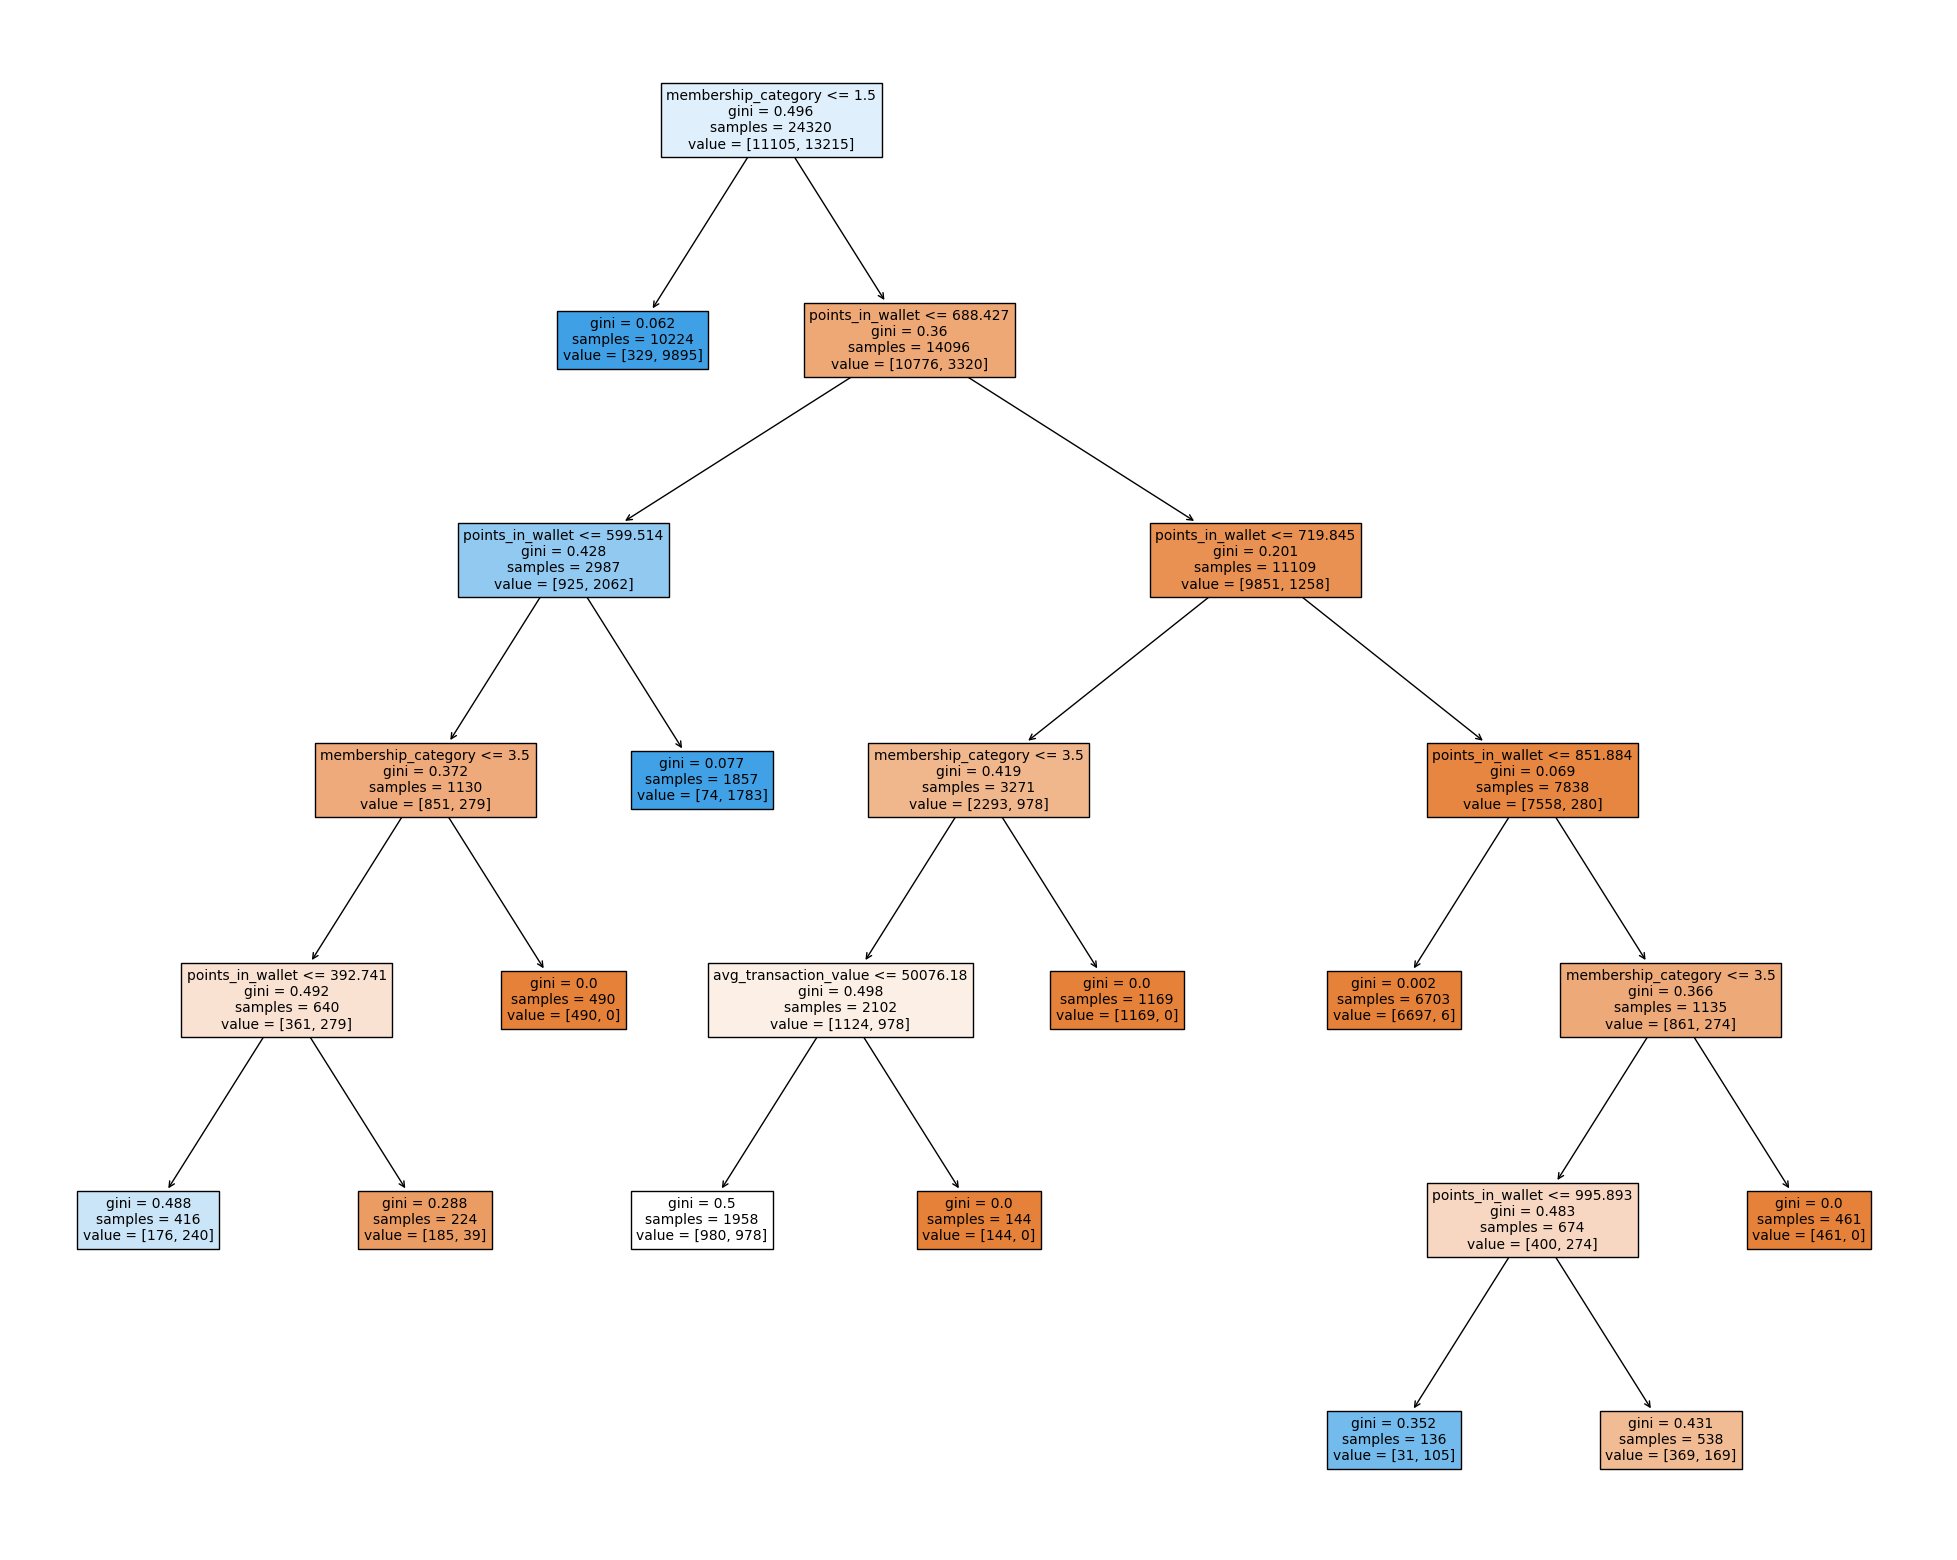

In [ ]:
fig = plt.figure(figsize=(25,20))
dectree_plot = plot_tree(best_model,feature_names=features, filled=True,fontsize= 10)

The resulting in decision tree especially utilizes membership_category and points_in_wallet for its predictive power.

The first step is to predict members with a high quality membership class as unlikely to churn (< 1.5). For the rest, it mostly compares whether a member belongs to a membership class >= 4 or <= 3 (medium membership class) and possesses above or below a specific number of points_in_wallets.

## Feature Importance for one-hot encoded Features

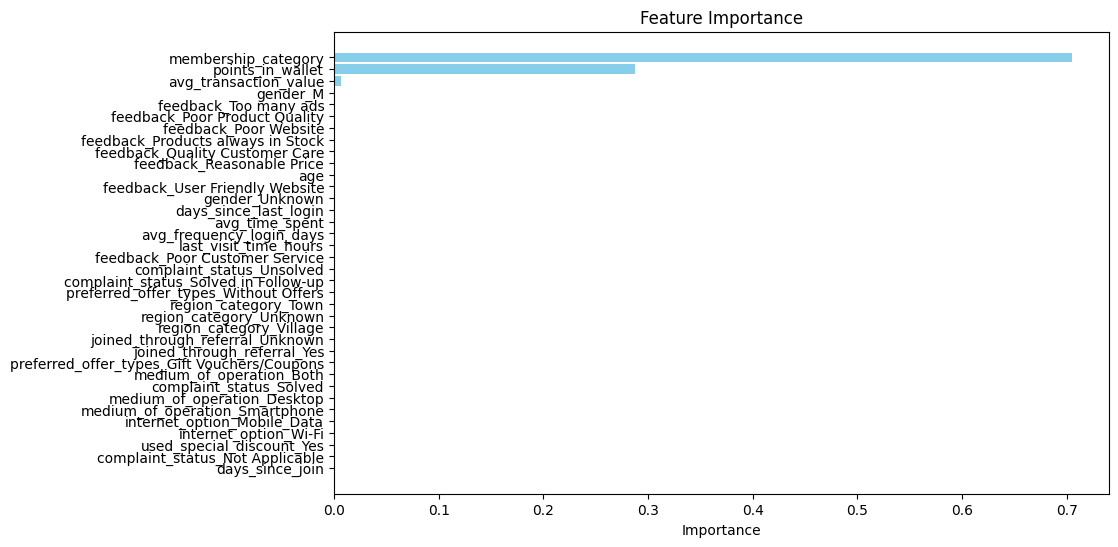

In [ ]:
#feature importance

importances = best_model.feature_importances_
features = X_train.columns


# create data frame for handling importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# sort by importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# create Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

With the hyperparameter tuned decision tree, we found that the prediction mainly depends on two features (membership_category and points_in_wallet) but also on avg_transaction_value. This analysis confirms our findings from the visualized decision tree.

## Save Model

In [ ]:
# Save model
with open('./model/model_dectree_grid.pkl', 'wb') as file:
    pickle.dump(best_model, file)

## Add predictions to dataframe for evaluation

In [ ]:
# create a data set with the predicted values for evaluation of test-data:
df_test_eval = df_test.copy()
y_pred = best_model.predict(X_test)
df_test_eval['y_pred'] = y_pred

# create a data set with the predicted values for evaluation of  train-test:
df_train_eval = df_train.copy()
y_pred_train = best_model.predict(X_train)
df_train_eval['y_pred'] = y_pred_train

# check if subfolder exists:
if not os.path.exists('./data/eval'):
        os.makedirs('./data/eval')

# write the dataframes with prediction outcome for next notebook 
df_train_eval.to_pickle('./data/eval/df_train_eval_decision_tree.pkl')
df_test_eval.to_pickle('./data/eval/df_test_eval_decision_tree.pkl')

For a vast majority of the predictions, the optimized decision tree results are very close 

- etwas sicherer
- bisschen bessere test prediction
- 2 variablen wirklich bedeutend, eine dritte führt zu leichten verbesserungen
- kaum overfitting --> erfolgreiche regularisierung
- überraschender Weise Feedback nicht wichtig, obwohl bei LogReg ultra wichtig
- cat boost classifier??? Target Encoding?